<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/Models/3D_Unet_Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import pickle
from sklearn.utils import resample

# Directories
batch_dir = '/content/drive/My Drive/ChronicAI/dataset/preprocessed_batches'
output_dir = '/content/drive/My Drive/ChronicAI/dataset/balanced_batches'
os.makedirs(output_dir, exist_ok=True)

# Constants
target_count_per_class = 80  # Exact target count per class

def balance_and_save_batch(batch_path, output_path):
    with open(batch_path, 'rb') as f:
        data, labels = pickle.load(f)

    balanced_data, balanced_labels = balance_classes(data, labels, target_count_per_class)

    with open(output_path, 'wb') as f:
        pickle.dump((balanced_data, balanced_labels), f)

def balance_classes(X, y, target_count):
    unique_labels = np.unique(y)
    balanced_data = []
    balanced_labels = []

    for label in unique_labels:
        X_label = X[y == label]
        y_label = y[y == label]

        if len(X_label) < target_count:
            # Resample with replacement to get exactly target_count samples
            X_resampled, y_resampled = resample(X_label, y_label,
                                                 replace=True,
                                                 n_samples=target_count,
                                                 random_state=42)
        else:
            # Select exactly target_count samples
            indices = np.random.choice(len(X_label), target_count, replace=False)
            X_resampled = X_label[indices]
            y_resampled = y_label[indices]

        balanced_data.append(X_resampled)
        balanced_labels.append(y_resampled)

    X_balanced = np.concatenate(balanced_data, axis=0)
    y_balanced = np.concatenate(balanced_labels, axis=0)

    return X_balanced, y_balanced

# Process each batch individually
batch_files = [f for f in os.listdir(batch_dir) if f.endswith('.pkl')]

for batch_file in batch_files:
    batch_path = os.path.join(batch_dir, batch_file)
    output_path = os.path.join(output_dir, batch_file)
    balance_and_save_batch(batch_path, output_path)
    print(f"Balanced and saved {batch_file}")

print("All batches have been processed and saved.")


Balanced and saved batch_0.pkl
Balanced and saved batch_1.pkl
Balanced and saved batch_2.pkl
Balanced and saved batch_3.pkl
Balanced and saved batch_4.pkl
Balanced and saved batch_5.pkl
Balanced and saved batch_6.pkl
Balanced and saved batch_7.pkl
Balanced and saved batch_8.pkl
Balanced and saved batch_9.pkl
Balanced and saved batch_10.pkl
Balanced and saved batch_11.pkl
Balanced and saved batch_12.pkl
Balanced and saved batch_13.pkl
Balanced and saved batch_14.pkl
Balanced and saved batch_15.pkl
Balanced and saved batch_16.pkl
Balanced and saved batch_17.pkl
Balanced and saved batch_18.pkl
Balanced and saved batch_19.pkl
Balanced and saved batch_20.pkl
All batches have been processed and saved.


In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from collections import Counter

# Directory containing the preprocessed batches
batch_dir = '/content/drive/My Drive/ChronicAI/dataset/balanced_batches'

def load_all_labels(batch_dir):
    all_labels = []
    for filename in os.listdir(batch_dir):
        if filename.endswith('.pkl'):
            batch_path = os.path.join(batch_dir, filename)
            with open(batch_path, 'rb') as f:
                _, labels = pickle.load(f)
                all_labels.extend(labels)
    return np.array(all_labels)

# Load all labels from batches
all_labels = load_all_labels(batch_dir)

# Count occurrences of each class
label_counts = Counter(all_labels)
df_label_counts = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count']).reset_index()
df_label_counts.columns = ['Label', 'Count']

print("Class Distribution:")
print(df_label_counts)


Class Distribution:
   Label  Count
0      2    880
1      1    400
2      0    400


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)

    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)

    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3], axis=-1)
    c5 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2], axis=-1)
    c6 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1], axis=-1)
    c7 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv3D(3, (1, 1, 1), activation='softmax')(c7)
    outputs = layers.GlobalAveragePooling3D()(outputs)  # Reduce spatial dimensions
    outputs = layers.Dense(1)(outputs)  # Output a single value

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

input_shape = (128, 128, 128, 1)  # Adjust according to your data
model = create_unet_model(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │            896 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │         27,680 │ conv3d[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 32) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 64) │        110,656 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 64) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32,     │        221,312 │ max_pooling3d_1[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32,     │        442,496 │ conv3d_4[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16,     │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        884,992 │ max_pooling3d_2[0][0]  │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 16, 16, 16,     │      1,769,728 │ conv3d_6[0][0]         │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose          │ (None, 32, 32, 32,     │        262,272 │ conv3d_7[0][0]         │
│ (Conv3DTranspose)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 32,     │              0 │ conv3d_transpose[0][0… │
│                      

 Total params: 5,599,783 (21.36 MB)

 Trainable params: 5,599,783 (21.36 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
import numpy as np
import pickle
import os
import tensorflow as tf

# Directory containing the balanced batches
balanced_batch_dir = '/content/drive/My Drive/ChronicAI/dataset/balanced_batches'

def data_generator(batch_dir, batch_size):
    batch_files = [f for f in os.listdir(batch_dir) if f.endswith('.pkl')]
    num_batches = len(batch_files)

    while True:
        for batch_idx in range(num_batches):
            batch_path = os.path.join(batch_dir, batch_files[batch_idx])
            with open(batch_path, 'rb') as f:
                data, labels = pickle.load(f)

                # Shuffle data and labels
                indices = np.arange(len(labels))
                np.random.shuffle(indices)
                data = data[indices]
                labels = labels[indices]

                # Yield data in batches
                for start in range(0, len(data), batch_size):
                    end = min(start + batch_size, len(data))
                    yield data[start:end], labels[start:end]

# Define the batch size for the generator
batch_size = 10
train_generator = data_generator(balanced_batch_dir, batch_size)

# Define your model architecture (example: 3D U-Net)
def create_model():
    input_shape = (128, 128, 128, 1)  # Adjust according to your data
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # Adjust output layer according to your labels
    ])
    return model

# Create model
model = create_model()

# Compile model with a learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Checkpoint Callback
checkpoint_path = '/content/drive/My Drive/ChronicAI/models/3d_unet_epoch_{epoch:02d}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model with the generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(os.listdir(balanced_batch_dir)) // batch_size,
    epochs=50,
    callbacks=[early_stopping, checkpoint_callback]
)

# Save model
model.save('/content/drive/My Drive/ChronicAI/models/3d_unet_model.keras')

# Save training history
import json
with open('/content/drive/My Drive/ChronicAI/models/training_history.json', 'w') as f:
    json.dump(history.history, f)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 39s/step - accuracy: 0.3333 - loss: 0.7386
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 47s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 91s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 41s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 40s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 88s 49s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 39s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 40s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 99s 60s/step -

Available keys in history: dict_keys(['accuracy', 'loss'])


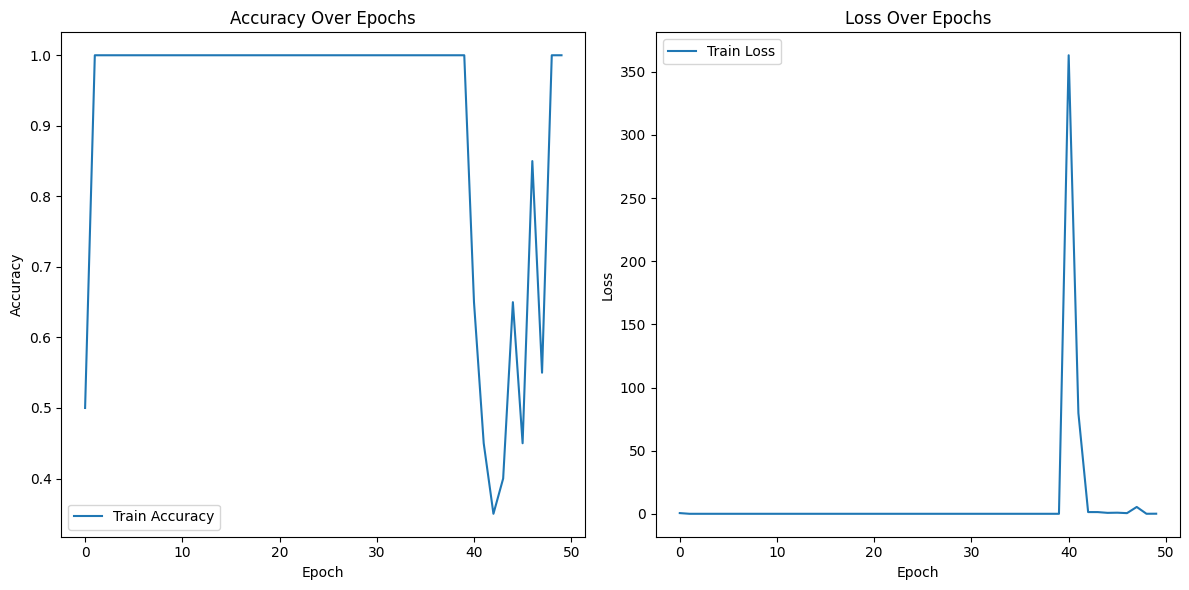

In [3]:
import json
import matplotlib.pyplot as plt

# Load training history from JSON file
with open('/content/drive/My Drive/ChronicAI/models/training_history.json', 'r') as f:
    history = json.load(f)

# Inspect available keys in the history
print("Available keys in history:", history.keys())

# Plot training & validation accuracy if available
plt.figure(figsize=(12, 6))

if 'accuracy' in history:
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
else:
    print("No accuracy data available.")

# Plot training & validation loss if available
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
